# CSC-40094 Assignment 1

Produce a Jupyter Notebook for training two classifiers on moons dataset i.e. Decision Tree and SVM and test them both. 

Task  
Calculate Mean Squared Error, Accuracy, Precision, Recall, and Receiver Operating curves of the models used.
Submit a two-page report arguing the appropriateness of the evaluation metric used. Which model is performing better? 

For example, if the precision of Decision Tree is better than SVM, but the accuracy of SVM is better than Decision Tree, then which one you will you select and why? (Note: It is also possible that all performance metrics agree for both models, so be careful).

In [1]:
# imports

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from joblib import parallel_backend

from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.datasets import make_moons
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    auc,
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
)
from sklearn.model_selection import train_test_split

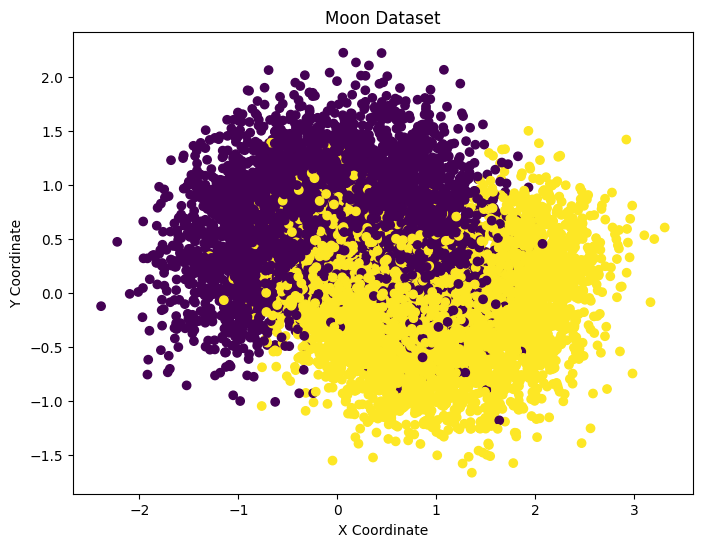

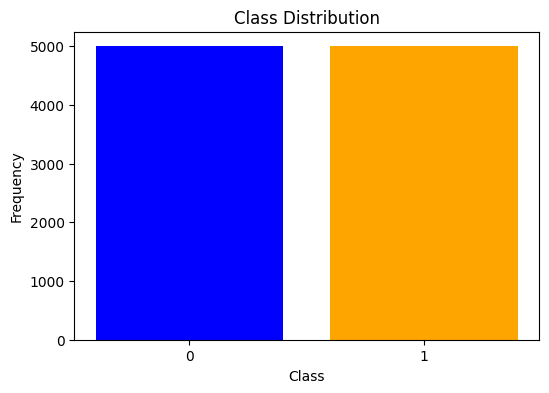

In [2]:
# moons dataset

# x is the generated sample.
# y is the class label for each sample, either a class 0 or class 1 moon.
x, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

# visualise the moons dataset
plt.figure(figsize=(8, 6))
plt.scatter(x[:, 0], x[:, 1], c=y, cmap="viridis")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Moon Dataset")
plt.show()

# Class Distributions
unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(unique, counts, color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(unique)
plt.show()

# Split the dataset into training and testing sets, with 80% of the data for
# training and 20% for testing.
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)


In [3]:
# Decision Tree

# Params represents the hyperparameters to tune:
# - max_depth: The maximum depth that the tree is allowed to reach.
#   Tuning Reason: A deeper tree can learn more detailed patterns in the data, but if the depth is too great,
#   it might overfit. Adjusting this parameter helps achieve a balance between model complexity and performance.
# - max_leaf_nodes: The maximum number of leaf nodes in the tree.
#   Tuning Reason: Restricting the number of leaf nodes can prevent the model from becoming overly complex and
#   overfitting to the training data.
# - min_samples_split: The minimum number of samples that a node must have to be split further.
#   Tuning Reason: Requiring a minimum number of samples at each split helps avoid creating nodes that are too
#   specific to the training data, thus reducing overfitting.
# - criterion: The metric used to evaluate the quality of a split.
#   Tuning Reason: The choice of criterion impacts the tree's performance. The "gini" index measures the impurity
#   of a node based on the probability of misclassification. "Entropy" measures the information gain, reflecting the
#   decrease in uncertainty about the target variable after a split.
params = {
    'max_depth': list(range(2, 50, 2)),
    'max_leaf_nodes': list(range(2, 50)),
    'min_samples_split': [2, 3, 4],
    'criterion' : ["gini", "entropy"],
}

# GridSearchCV is a function that performs an exhaustive search over a specified
# parameter grid, evaluating the model performance at each grid point using
# 10-fold cross validation.
# Accuracy is used as the scoring metric to evaluate the performance of the
# model.
dt_grid_search_cv = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    params,
    n_jobs=-1,
    verbose=1,
    cv=10,
    scoring="accuracy",
)

# Fit the grid search to the data
dt_grid_search_cv.fit(x_train, y_train)

# Get the best estimator
best_dt = dt_grid_search_cv.best_estimator_

# Predict against the best estimator model, using the test data
y_pred_dt = best_dt.predict(x_test)

# Output model information for the best estimator
print("Best estimator:", dt_grid_search_cv.best_estimator_)
print("Best parameters:", dt_grid_search_cv.best_params_)

# Output the performance metrics for the best estimator
print("MSE:", mean_squared_error(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("F1 score:", f1_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("AUC:", roc_auc_score(y_test, y_pred_dt))

Fitting 10 folds for each of 6912 candidates, totalling 69120 fits
Best estimator: DecisionTreeClassifier(max_depth=10, max_leaf_nodes=32, random_state=42)
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 32, 'min_samples_split': 2}
MSE: 0.1265
Accuracy: 0.8735
F1 score: 0.8733099649474211
Precision: 0.8633663366336634
Recall: 0.8834853090172239
AUC: 0.8736281431561934


In [11]:
# Support Vector Machine, specifically a Support Vector Classifier (SVC), as
# the dataset is a binary classification problem (moons dataset).

# Params represents the hyperparameters to tune:
# - C: the regularization parameter. The regularization strength is inversely
#   proportional to C.
#   Tuning Reason: A smaller C value allows for a larger margin, which may
#   result in some misclassified points but can help prevent overfitting. Conversely,
#   a larger C value allows for a smaller margin, aiming to classify all points correctly,
#   which might lead to overfitting.
# - kernel: the type of kernel to be used in the algorithm.
#   Tuning Reason: The 'rbf' kernel is suitable for non-linear data, while the 'poly'
#   kernel can model polynomial relationships. Both are effective for non-linear datasets.
# - gamma: the kernel coefficient for 'rbf' and 'poly' kernels.
#   Tuning Reason: A smaller gamma value means each point's influence is broader, creating
#   a smoother decision boundary and potentially reducing overfitting. A larger gamma value
#   means each point's influence is narrower, allowing for a more complex decision boundary
#   but increasing the risk of overfitting.
# - degree: the degree of the polynomial kernel.
#   Tuning Reason: Testing degrees such as quadratic (2), cubic (3), and quartic (4)
#   helps capture increasingly complex data relationships.
# - coef0: the independent term in the polynomial kernel.
#   Tuning Reason: This parameter controls the impact of higher-order polynomial terms.
#   Setting coef0 to 1 includes higher-order terms, while setting it to 0 excludes them.

#
# NOTE: The dataset could benefit from feature scaling to enable the SVM to
# define a decision boundary that separates the classes more effectively. Instead
# of scaling the features manually, the polynomial kernel can inherently capture
# the non-linear relationships in the data.
params = [
    {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'gamma': [0.01, 0.1, 1], },
    {'C': [0.1, 1, 10], 'kernel': ['poly'], 'gamma': [0.01, 0.1, 1], 'degree': [2, 3, 4], 'coef0': [0, 1]},
]

# GridSearchCV is a function that performs an exhaustive search over a specified
# parameter grid, evaluating the model performance at each grid point using
# 10-fold cross validation.
# Accuracy is used as the scoring metric to evaluate the performance of the
# model.
# Note: I am using the threading backend as the default backend (loky) was
# causing issues with timeouts with the SVC model. I understand that this might
# cause some lock contention with the Python GIL, but it should be fine for this
# small dataset.
with parallel_backend('threading'):
    svc_grid_search_cv = GridSearchCV(
        SVC(random_state=42, probability=True),
        params,
        n_jobs=-1,
        verbose=1,
        cv=10,
        scoring="accuracy",
    )

# Fit the grid search to the data
svc_grid_search_cv.fit(x_train, y_train)

# Get the best estimator
best_svm = svc_grid_search_cv.best_estimator_

# Predict against the best estimator model, using the test data
y_pred_svm = best_svm.predict(x_test)

# Output model information for the best estimator
print("Best estimator:", svc_grid_search_cv.best_estimator_)
print("Best parameters:", svc_grid_search_cv.best_params_)

# Output the performance metrics for the best estimator
print("MSE:", mean_squared_error(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1 score:", f1_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("AUC:", roc_auc_score(y_test, y_pred_svm))

Fitting 10 folds for each of 63 candidates, totalling 630 fits


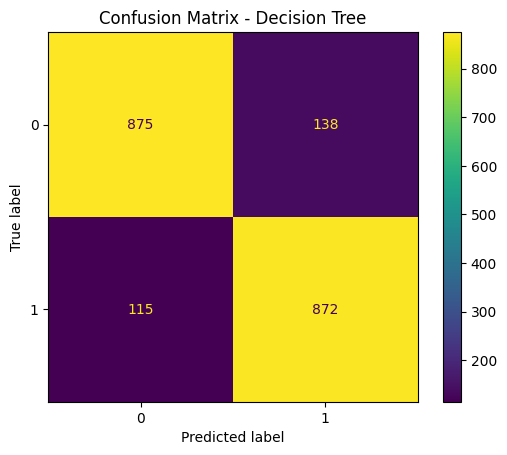

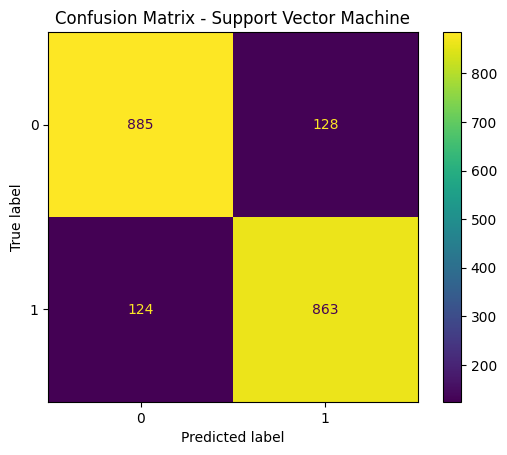

In [5]:
# Confusion Matrix

# Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=best_dt.classes_)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=best_dt.classes_)
disp_dt.plot()
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Support Vector Machine
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=best_svm.classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=best_svm.classes_)
disp_svm.plot()
plt.title("Confusion Matrix - Support Vector Machine")
plt.show()

In [6]:
# Calculate the accuracy on the training set, to test for overfitting

# Decision Tree
y_pred_train_dt = best_dt.predict(x_train)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_train_dt = accuracy_score(y_train, y_pred_train_dt)

# Support Vector Machine
y_pred_train_svm = best_svm.predict(x_train)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)

# Print the accuracies on the training and test sets, a higher accuracy on the
# training set indicates overfitting.
print("Decision Tree - Training Accuracy:", accuracy_train_dt)
print("Decision Tree - Test Accuracy:", accuracy_dt)

print("SVM - Training Accuracy:", accuracy_train_svm)
print("SVM - Test Accuracy:", accuracy_svm)

Decision Tree - Training Accuracy: 0.868125
Decision Tree - Test Accuracy: 0.8735
SVM - Training Accuracy: 0.864125
SVM - Test Accuracy: 0.874


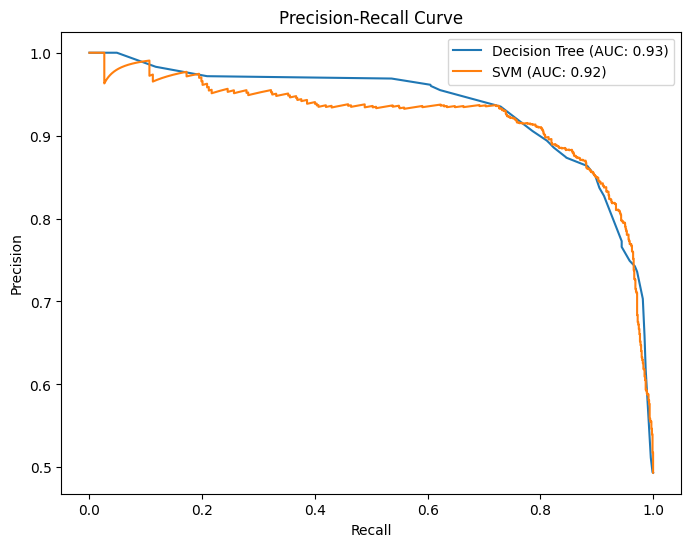

In [7]:
# print precision and recall curves

# predict probabilities of the positive class (class 1 moons) for Decision Tree
y_pred_proba_dt = best_dt.predict_proba(x_test)[:, 1]

# predict probabilities of the positive class (class 1 moons) for SVM
y_pred_proba_svm = best_svm.predict_proba(x_test)[:, 1]

precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_proba_dt)
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_pred_proba_svm)

# add auc
auc_dt = auc(recall_dt, precision_dt)
auc_svm = auc(recall_svm, precision_svm)

plt.figure(figsize=(8, 6))
plt.plot(recall_dt, precision_dt, label="Decision Tree (AUC: {:.2f})".format(auc_dt))
plt.plot(recall_svm, precision_svm, label="SVM (AUC: {:.2f})".format(auc_svm))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()



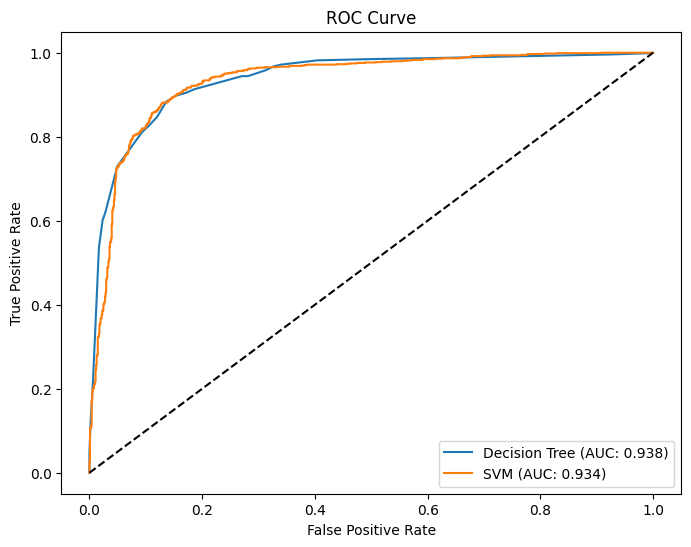

In [8]:
# print roc curves

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)

# calculate auc
auc_dt = auc(fpr_dt, tpr_dt)
auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label="Decision Tree (AUC: {:.3f})".format(auc_dt))
plt.plot(fpr_svm, tpr_svm, label="SVM (AUC: {:.3f})".format(auc_svm))
# adds a reference line for a random classifier
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.show()

In [9]:
# Below here is an exploration into the thresholds for the models

# Create a range of threshold values
thresholds = np.arange(0, 1.01, 0.01)

# Initialize variables to store the best threshold and accuracy for SVM
best_svm_threshold = float('-inf')
best_svm_accuracy = float('-inf')

# Iterate over each threshold value
for threshold in thresholds:
    # Convert probabilities to binary predictions using the current threshold
    svm_predictions = (y_pred_proba_svm > threshold).astype(int)
    dt_predictions = (y_pred_proba_dt > threshold).astype(int)

    # Calculate the accuracy for SVM and DT models
    svm_accuracy = accuracy_score(y_test, svm_predictions)
    dt_accuracy = accuracy_score(y_test, dt_predictions)

    # Check if SVM outperforms DT at the current threshold
    if svm_accuracy > dt_accuracy and svm_accuracy > best_svm_accuracy:
        best_svm_threshold = threshold
        best_svm_accuracy = svm_accuracy

print(f"Best SVM threshold: {best_svm_threshold}")
print(f"SVM accuracy at the best threshold: {best_svm_accuracy}")

Best SVM threshold: 0.49
SVM accuracy at the best threshold: 0.8745


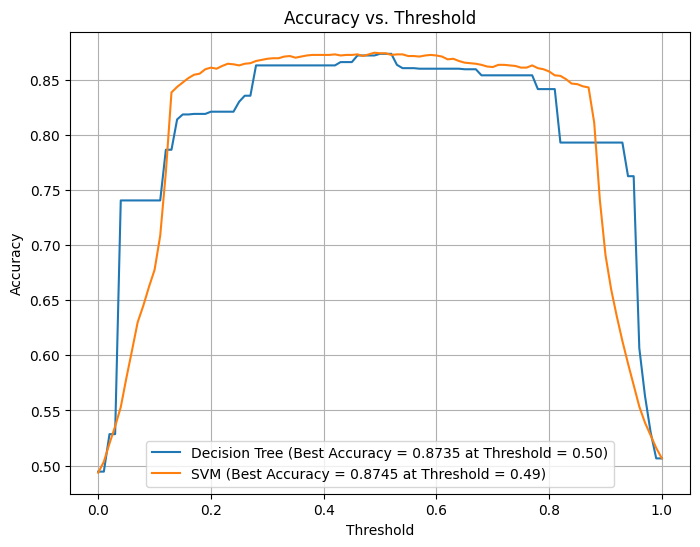

In [10]:
# Create a range of threshold values
thresholds = np.arange(0, 1.01, 0.01)

# Calculate the accuracy for SVM and DT models at each threshold
svm_accuracies = [accuracy_score(y_test, y_pred_proba_svm > t) for t in thresholds]
dt_accuracies = [accuracy_score(y_test, y_pred_proba_dt > t) for t in thresholds]

# Find the best threshold and accuracy for SVM
best_svm_threshold = thresholds[np.argmax(svm_accuracies)]
best_svm_accuracy = np.max(svm_accuracies)

# Find the best threshold and accuracy for DT
best_dt_threshold = thresholds[np.argmax(dt_accuracies)]
best_dt_accuracy = np.max(dt_accuracies)

# Plot the accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(thresholds, dt_accuracies, label=f'Decision Tree (Best Accuracy = {best_dt_accuracy:.4f} at Threshold = {best_dt_threshold:.2f})')
plt.plot(thresholds, svm_accuracies, label=f'SVM (Best Accuracy = {best_svm_accuracy:.4f} at Threshold = {best_svm_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()